In [1]:
import matplotlib.pyplot as plt
import pdb
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 22
import numpy as np
from embeddings import load_embeddings
from lower_bound import lower_bound
from mechanism_base import OPTMech, ExponentialMechanism, EuclideanMechanism, ConstrOPTMech
from constr_mech import ExpConstrOPTMech
from tqdm import tqdm
import time
import pickle
import sys

In [2]:
from run_experiments import get_data_once, get_actual_epsilon

def get_data(mech, epsilons, save_path = None, stop_after = np.inf):
    res = []
    for e in epsilons:
        print(e)
        sys.stdout.flush()
        mech.epsilon = e 
        r = get_data_once(mech)
        res.append(r)
        if r['success'] and r['epsilon'] > stop_after:
            break

    res_dict = {}
    for i in range(0, len(res)):
        for k, v in res[i].items():
            if k in res_dict:
                res_dict[k].append(v)
            else:
                res_dict[k] = [v] 
    res_dict['name'] = mech.name
    res_dict['distance_matrix'] = mech.embeddings.distance_matrix
    if save_path is not None:
        pickle.dump(res_dict, open(save_path, 'wb'))
    return res_dict

In [3]:
exp_label = 'ExpMech'
opt_label = 'OPTMech'
constr_label = 'ConstrOPTMech'
spanner_label = 'SpannerMech'
weighted_label = 'WeightedExpMech'
euclid_label = 'EuclidMech'

In [4]:
#50 points in the random embedding
emb = load_embeddings('data/geolife.txt', 50)
emb.save_ann()

In [5]:
euclid_mech = EuclideanMechanism(1.0, 10000, emb, True)
#euclid_data = get_data(euclid_mech, np.geomspace(0.01, 0.5, 10), 'data/50pts/geo/euclid_data.pkl')
euclid_data = pickle.load(open('data/50pts/geo/euclid_data.pkl', 'rb'))
euclid_data['name'] = euclid_label

In [6]:
exp_mech = ExponentialMechanism(1.0, emb)
exp_data = get_data(exp_mech, np.geomspace(0.02, 1.5, 10))
exp_data['name'] = exp_label

0.02
0.032312468423897206
0.05220478078226766
0.0843432665301749
0.1362669568262311
0.2201560869834078
0.3556893304490063
0.5746600129425323
0.9284341761340966
1.5


In [7]:
opt_mech = OPTMech(1.0, emb, max_exp=10)
opt_data = get_data(opt_mech, np.geomspace(0.02, 1.5, 10), 'data/50pts/geo/opt_data.pkl')
opt_data = pickle.load(open('data/50pts/geo/opt_data.pkl', 'rb'))
opt_data['name'] = opt_label

0.02
0.032312468423897206
0.05220478078226766
0.0843432665301749
0.1362669568262311
0.2201560869834078
0.3556893304490063
0.5746600129425323
0.9284341761340966
1.5


In [8]:
spanner, _ = emb.get_spanner(2.0)
spanner_opt_mech = OPTMech(1.0, emb, spanner, max_exp = 10)
span_data = get_data(spanner_opt_mech, np.geomspace(0.02, 0.4, 10), 'data/50pts/geo/spanner_data.pkl')
span_data = pickle.load(open('data/50pts/geo/spanner_data.pkl', 'rb'))
span_data['name'] = spanner_label

0.02
0.02789901587924842
0.038917754351527785
0.05428835233189814
0.07572958018829298
0.1056390380101001
0.1473612599456155
0.20556170656043912
0.2867484657747547
0.4


In [9]:
constr_opt_mech = ConstrOPTMech(1.0, emb, [0.001, 0.1, 1.0], max_exp = 10)
constr_opt_mech.set_nns_heuristic(10)
constr_data = get_data(constr_opt_mech, np.geomspace(0.02, 2.5, 10), 'data/50pts/geo/constr_data.pkl')
constr_data = pickle.load(open('data/50pts/geo/constr_data.pkl', 'rb'))
constr_data['name'] = constr_label

0.02
0.03419951893353395
0.058480354764257315
0.1
0.17099759466766967
0.2924017738212865
0.49999999999999994
0.8549879733383481
1.4620088691064324
2.5


In [10]:
def correct_data(x, y):
    idxs = np.argsort(x)
    lowest = y[idxs[0]]
    include = [True]
    for i in range(1, len(x)):
        if y[idxs[i]] < lowest:
            lowest = y[idxs[i]]
            include.append(True)
        else:
            include.append(False)
    return idxs[include]

def plot_mech(mech, ax, utility_quantile, delta):
    if 'epsilon_correct' in mech:
        x = mech['epsilon_correct'].copy()
    else:
        x = np.array( [get_actual_epsilon(x, mech['distance_matrix'], delta).max() for x in mech['trans']] )
        mech['epsilon_correct'] = x.copy()
    #x = np.array(mech['epsilon'])
    y = np.array(mech['utility'])
    y = np.quantile(y, utility_quantile, axis=1)
    include = correct_data(x,y)
    x = x[include]
    y = y[include]
    ax.plot(x, y, label=mech['name'])
    #ax.fill_between(x, y0, y1, alpha=0.3, label = mech['name'], color=color)
    plt.legend()

In [11]:
epsilons_lb = np.geomspace(0.02, 1.5, 10)
lb = lower_bound(emb.distance_matrix, epsilons_lb)

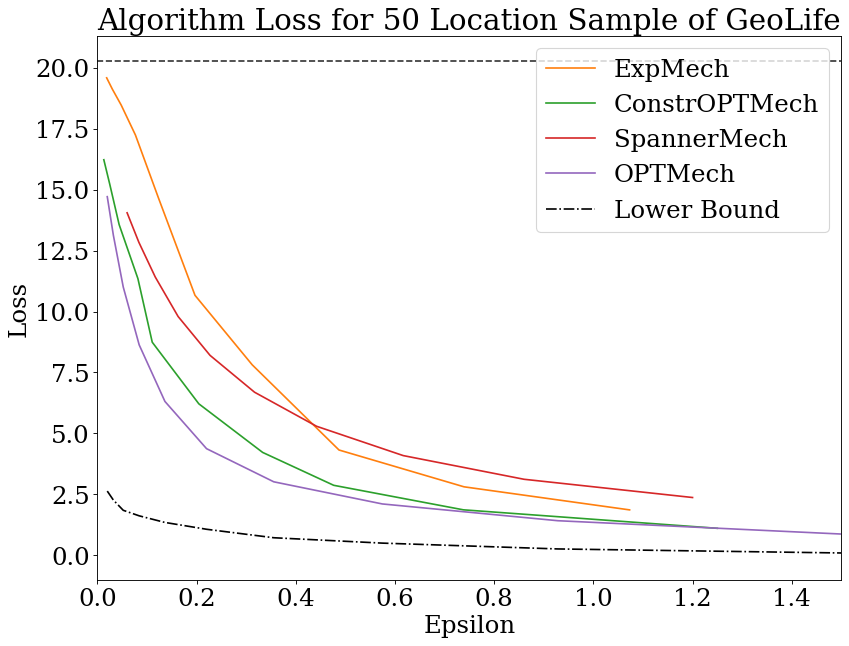

In [12]:
fig, ax = plt.subplots()
ax.set_xlabel('Epsilon')
ax.set_ylabel('Loss')
ax.set_title('Algorithm Loss for 50 Location Sample of GeoLife')
ax.hlines(np.quantile(emb.distance_matrix.mean(axis=1), 0.95), 0, 2.0, color='k', linestyles='dashed', alpha=0.8)
#plot_mech(euclid_data, ax, 0.95, 0.001)
plt.plot([0], [0])
for res in [exp_data, constr_data, span_data, opt_data]:
    plot_mech(res, ax, 0.95, 0.001)
ax.set_xlim(0, 1.5)
ax.plot(epsilons_lb, lb, 'k-.', label='Lower Bound')
ax.legend()

In [13]:
np.quantile( np.array(opt_data['time']), 0.5)

20.39273965358734

In [14]:
opt_data['lp_shape'][0][0]

250000

In [15]:
emb = load_embeddings('data/geolife.txt', 200)

In [16]:
exp_data = pickle.load(open('data/200pts/geo/exp_data.pkl', 'rb'))
exp_data['name'] = exp_label
constr_data = pickle.load(open('data/200pts/geo/constr_data_10.pkl', 'rb'))
constr_data['name'] = constr_label
span_data = pickle.load(open('data/200pts/geo/spanner_data.pkl', 'rb'))
span_data['name'] = spanner_label
euclid_data = pickle.load(open('data/200pts/geo/euclid_data.pkl', 'rb'))
euclid_data['name'] = euclid_label

In [17]:
lb = lower_bound(emb.distance_matrix, epsilons_lb)

/home/jimola/dptextgeometry/run_experiments.py:298: RuntimeWarning: divide by zero encountered in log
  eps = np.log(ratios[idxs[cutoff]]) / d


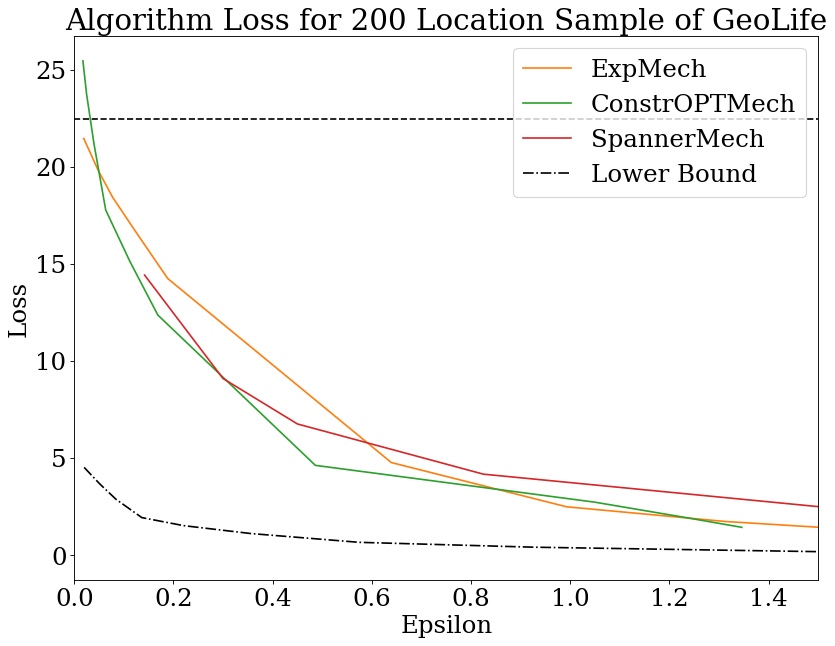

In [18]:
fig, ax = plt.subplots()
ax.set_xlabel('Epsilon')
ax.set_ylabel('Loss')
ax.set_title('Algorithm Loss for 200 Location Sample of GeoLife')
#plot_mech(euclid_data, ax, 0.95, 0.002)
plt.plot([0], [0])
for res in [exp_data, constr_data, span_data]:
    plot_mech(res, ax, 0.95, 0.001)
ax.plot(epsilons_lb, lb, 'k-.', label='Lower Bound')
ax.hlines(np.quantile(emb.distance_matrix.mean(axis=1), 0.95), 0, 3.0, color='k', linestyles='dashed')
ax.set_xlim(0, 1.5)
ax.legend()

In [19]:
exp_data = pickle.load(open('data/vary_pts/geo/exp_data.pkl', 'rb'))
constr_data = pickle.load(open('data/vary_pts/geo/constr_data_10.pkl', 'rb'))
constr_data_5 = pickle.load(open('data/vary_pts/geo/constr_data_5.pkl', 'rb'))
spanner_data = pickle.load(open('data/vary_pts/geo/spanner_data.pkl', 'rb'))

In [20]:
def multi_point_loss(data, epsilon, utility_quantile, delta=0.001):
    loss = []
    pts = []
    for k, dat in data.items():
        #emb = load_embeddings('data/fasttext_sample_1000_0.5.txt', k)
        if 'utility' in dat and 'trans' in dat:
            m = dat['distance_matrix']
            x = np.array([ get_actual_epsilon(t, m, delta).max() for t in dat['trans']])
            print(x)
            #x = np.array( dat['epsilon'] )
            y = np.array( list(map(lambda x: np.quantile(x, utility_quantile), dat['utility'])) )
            include = correct_data(x,y)
            x = x[include]
            y = y[include]
            if epsilon < x[0] or epsilon > x[-1]:
                print('possible interpolation inconsistency')
                print(epsilon)
                print(x)
            loss.append(np.interp(epsilon, x, y))
            pts.append(k)
    return (pts, loss)

In [19]:
exp_loss2 = multi_point_loss(exp_data, 0.25, 0.95, 0.001)
constr_loss2 = multi_point_loss(constr_data, 0.25, 0.95, 0.001)
constr_loss3 = multi_point_loss(constr_data_5, 0.25, 0.95, 0.001)
spanner_loss2 = multi_point_loss(spanner_data, 0.25, 0.95, 0.001)
#spanner_const_loss2 = multi_point_loss(spanner_const_data, 2.0, 0.95)
#weight_exp_loss2 = multi_point_loss(weight_exp_data, 2.0, 0.95)

[0.09092929 0.13568958 0.17931207 0.22264222 0.26535769 0.30739771
 0.34873081]
[0.0917164  0.13431792 0.17787189 0.22137087 0.26434376 0.30672446
 0.34846248]
[0.09214208 0.13530663 0.1780758  0.2220791  0.26543564 0.30787511
 0.34910684]
[0.09546425 0.14254318 0.18835275 0.23177966 0.27145571 0.31167278
 0.35488473]
[0.09402589 0.13994782 0.18533702 0.22965025 0.27277404 0.31668776
 0.35981721]
[0.09368305 0.13811506 0.18187257 0.22510963 0.26768357 0.31077583
 0.35319096]
[0.0923933  0.13596643 0.17847812 0.22026648 0.26291559 0.30494649
 0.3462503 ]
[0.09190164 0.13604155 0.18060737 0.22470875 0.2679006  0.30990753
 0.35051115]
[0.08177951 0.09908285 0.14006345 0.17019784 0.20862975 0.24612875
 0.28400561]
[0.07865151 0.10733569 0.14529956 0.18707935 0.21488093 0.27656035
 0.28522632]
[0.07368622 0.10479433 0.14377853 0.18841785 0.22946796 0.24895321
 0.28749984]
[0.08877946 0.12847935 0.15588359 0.19852704 0.24426749 0.30159885
 0.30859476]
[0.08225384 0.13055842 0.15567448 0.1992

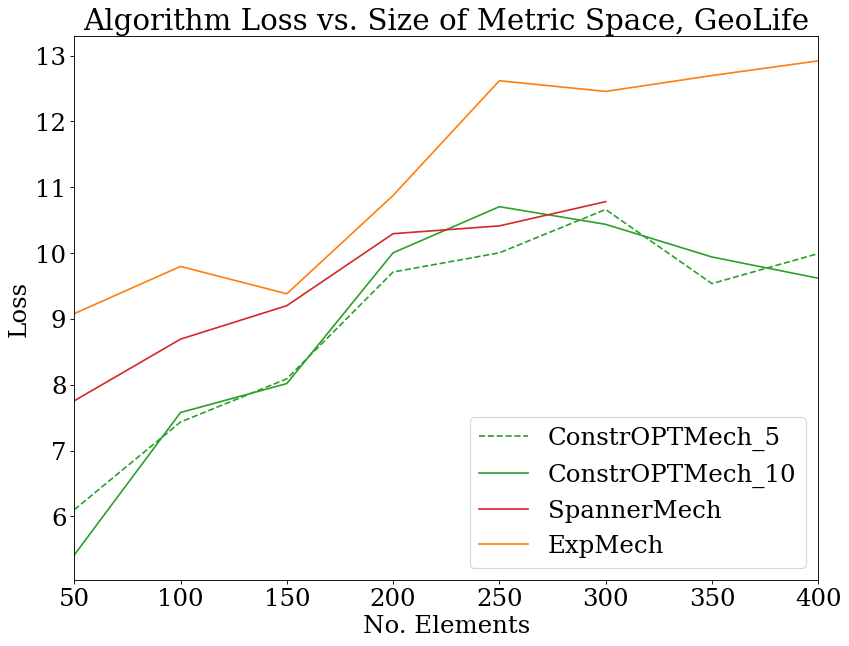

In [18]:
fig, ax = plt.subplots()
ax.plot(*constr_loss3, label=constr_label+'_5', color='tab:green', linestyle='dashed')
ax.plot(*constr_loss2, label=constr_label+'_10', color='tab:green')
ax.plot(*spanner_loss2, label=spanner_label, color='tab:red')
ax.plot(*exp_loss2, label=exp_label, color='tab:orange')
ax.set_xlim(50, 400)
ax.set_xlabel('No. Elements')
ax.set_ylabel('Loss')
ax.set_title('Algorithm Loss vs. Size of Metric Space, GeoLife')
ax.legend()

In [10]:
pts = [50, 150, 300, 400]
ans = ''
for p in pts:
    ans += '%d & ' % p
print(ans[:-2] + '\\\\ \\hline')
ans = ''
for p in pts:
    mem = constr_data[p]['lp_shape'][0][0]
    time = np.quantile(constr_data[p]['time'][0], 0.5)
    ans += '%0.2f sec, \\num{%0.2e} nz & ' % (time, mem)
print(ans[:-2] + '\\\\ \\hline')
ans = ''
for p in pts:
    mem = constr_data_5[p]['lp_shape'][0][0]
    time = np.quantile(constr_data_5[p]['time'][0], 0.5)
    ans += '%0.2f sec, \\num{%0.2e} nz & ' % (time, mem)
print(ans[:-2] + '\\\\ \\hline')
ans = ''
for p in pts[:-1]:
    mem = spanner_data[p]['lp_shape'][0][0]
    if 'time' in spanner_data[p]:
        time = np.quantile(spanner_data[p]['time'][0], 0.5)
        ans += '%0.2f sec, \\num{%0.2e} nz & ' % (time, mem)
    else:
        ans += '-- sec, \\num{%0.2e} nz & ' % (mem)
print(ans[:-2] + '\\\\ \\hline')

50 & 150 & 300 & 400 \\ \hline
1.41 sec, \num{1.74e+04} nz & 13.85 sec, \num{8.05e+04} nz & 80.24 sec, \num{2.51e+05} nz & 169.52 sec, \num{4.13e+05} nz \\ \hline
0.40 sec, \num{8.30e+03} nz & 12.53 sec, \num{5.47e+04} nz & 66.28 sec, \num{1.99e+05} nz & 145.74 sec, \num{3.46e+05} nz \\ \hline
1.01 sec, \num{1.56e+04} nz & 40.59 sec, \num{1.49e+05} nz & 928.72 sec, \num{6.05e+05} nz \\ \hline
